<a href="https://colab.research.google.com/github/milipaget/TP2-Redes-Neuronales-Paget/blob/main/TP2_Redes_Neuronales_Milagros_Paget.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip drive/MyDrive/PhC-C2DH-U373.zip

Archive:  drive/MyDrive/PhC-C2DH-U373.zip
replace PhC-C2DH-U373/01/t000.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

In [4]:
from PIL import Image

# Cargo Train y Val

Train será aumentado

In [5]:
#Importo las imágenes del train y validación de PhC-C2DH-U373.zip
train_path = Path("PhC-C2DH-U373/01/").glob("**/*tif")
val_path = Path("PhC-C2DH-U373/02/").glob("**/*tif")

In [6]:
train_images = list()
train_masks = list()
for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))
    train_masks.append(np.array(Image.open(f'PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

val_images = list()
val_masks = list()

for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))
    val_masks.append(np.array(Image.open(f'PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

In [7]:
train_images = np.vstack(train_images)/255
train_masks = 1*(np.vstack(train_masks) > 0)
val_images = np.vstack(val_images)/255
val_masks = 1*(np.vstack(val_masks) >0 )

# Imágenes de train sin aumentar

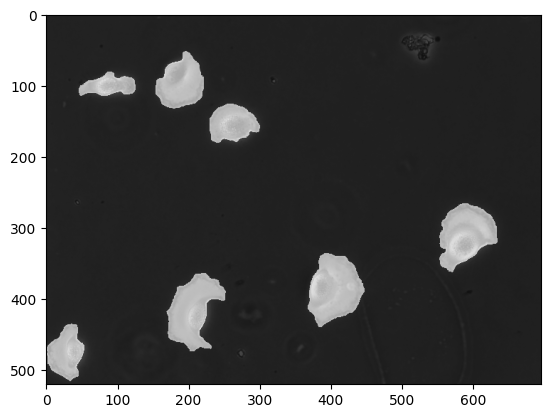

In [8]:
#Ploteo sin data augmentation
idx = 100
plt.imshow(train_images[idx], vmin=0, vmax=1, cmap="gray")
plt.imshow(train_masks[idx], vmin=0, vmax=1, cmap="gray",alpha=0.6)
plt.show()

# Armo datasets de tensorflow y aumento

Para mantener sincronizada la aumentación entre la imagen y la máscara, armo una entrada de 4 canales que de descompondrán durante el entrenamiento.

In [9]:
x_train = np.stack((train_images, train_masks ),axis=-1)
x_val = np.stack((val_images, val_masks ),axis=-1)

In [10]:
x_train[0,:,:,0].max()

0.7254901960784313

In [11]:
len(x_train)

115

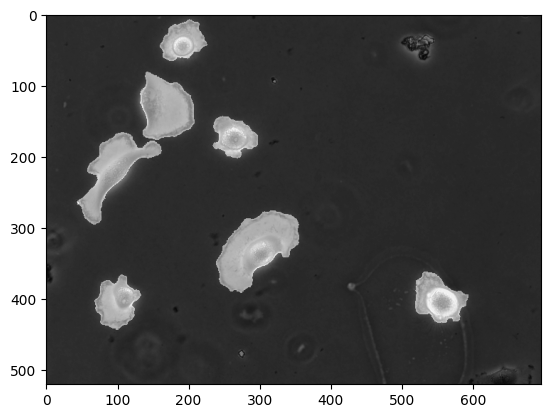

In [12]:
#Ploteo con data augmentation
plt.imshow(x_train[0,:,:,0], cmap="gray")
plt.imshow(x_train[0,:,:,1], cmap="gray", alpha = 0.5)

In [13]:
from tensorflow.keras.models import Sequential

# Armo una red mínima fully convolutional con Atrous Convolutions

In [14]:
filters = 16
kernel_size = 10
def get_red_seg():
    return Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1, input_shape = (None,None,1)),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 2),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 4),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 8),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1),
        tf.keras.layers.Conv2D(1, kernel_size,padding="same", activation = "sigmoid", dilation_rate = 1)
    ])


El objetivo de esta red fully convolutional con Atrous Convolutions es incrementar el campo de recepción de la red, permitiendo entender la imagen general en lugar de los detalles. Además permiten reducir el costo computacional y brindan una vista de la red sin mayor profundidad.

Información sobre Atrous Convolutions:
https://medium.com/hitchhikers-guide-to-deep-learning/10-introduction-to-deep-learning-with-computer-vision-types-of-convolutions-atrous-convolutions-3cf142f77bc0

# Armo la red de preprocesamiento para hacer aumentación en la GPU que no tengo

In [15]:
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        #tf.keras.layers.RandomZoom((-0.1,0.3)),
        #tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        #tf.keras.layers.RandomRotation((0,1)),
        #tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

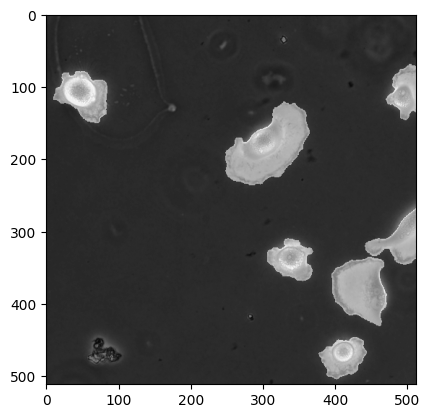

In [16]:
preproc = get_preproc()
aux_elem = preproc(x_train[0])
plt.imshow(aux_elem[:,:,0], cmap="gray")
plt.imshow(aux_elem[:,:,1], cmap="gray", alpha = 0.5)

In [17]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [18]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.dice = False


    def call(self, inputs):
        #img_mask = self.red_preproc = red_preproc(inputs)
        return self.red_segmentacion(inputs[:,:,:1])

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            data_aug = self.red_preproc(data)
            loss = self._compute_loss(data_aug)
            #print(K.mean(loss))

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.red_segmentacion.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.red_segmentacion.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        data_preproc = self.red_preproc_val(data)
        loss = self._compute_loss(data_preproc)
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        #aux = self.red_preproc(data)
        mask_out = self.red_segmentacion(data[:,:,:,:1])
        #print(mask_out.shape)
        #print(data[:,:,:,1:2].numpy())
        if self.dice == True:
            loss = dice_loss(data[:,:,:,1:2], mask_out)
        else:
            loss = tf.keras.losses.binary_crossentropy(data[:,:,:,1:2], mask_out)
        return loss

    # property
    # def metrics(self):
    #     # We need to list our metrics here so the `reset_states()` can be
    #     # called automatically.
    #     return [self.loss_tracker]

In [19]:
#Armo una red fully convolutional con las Atrous Convolutions
red_falopa = get_red_seg()

In [20]:
red_falopa.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    1616      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-tr

In [21]:
preproc= get_preproc()
preproc_val = get_preproc_val()
red_falopa = get_red_seg()
model = SegmentationModel(preproc, red_falopa,preproc_val)

In [22]:
#Compilo el modelo
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [23]:
len(x_val)

115

In [24]:
#Entreno la red
model.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=32, validation_split = 0.5, verbose = 1)

Epoch 1/32
8/8 [==============================] - 75s 2s/step - loss: 0.6828 - val_loss: 0.6400
Epoch 2/32
8/8 [==============================] - 9s 1s/step - loss: 0.5700 - val_loss: 0.3024
Epoch 3/32
8/8 [==============================] - 8s 1s/step - loss: 0.3691 - val_loss: 0.1707
Epoch 4/32
8/8 [==============================] - 8s 1s/step - loss: 0.3443 - val_loss: 0.2485
Epoch 5/32
8/8 [==============================] - 8s 1s/step - loss: 0.3448 - val_loss: 0.1891
Epoch 6/32
8/8 [==============================] - 8s 1s/step - loss: 0.3402 - val_loss: 0.2049
Epoch 7/32
8/8 [==============================] - 8s 1s/step - loss: 0.3344 - val_loss: 0.2030
Epoch 8/32
8/8 [==============================] - 9s 1s/step - loss: 0.3323 - val_loss: 0.1938
Epoch 9/32
8/8 [==============================] - 9s 1s/step - loss: 0.3236 - val_loss: 0.1919
Epoch 10/32
8/8 [==============================] - 8s 1s/step - loss: 0.3170 - val_loss: 0.1808
Epoch 11/32
8/8 [==============================]

In [25]:
pred = red_falopa(x_val[0:1,:,:,0])
pred.shape

TensorShape([1, 520, 696, 1])

In [26]:
pred.numpy().max()

0.9656122

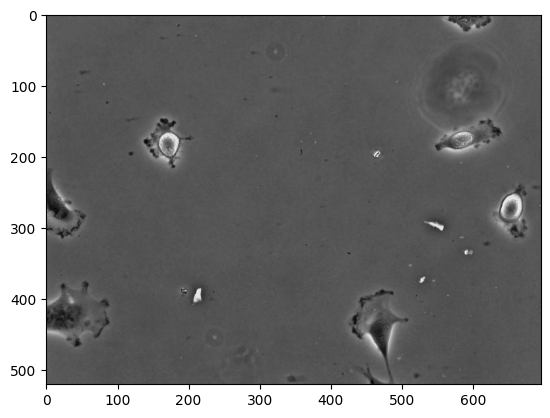

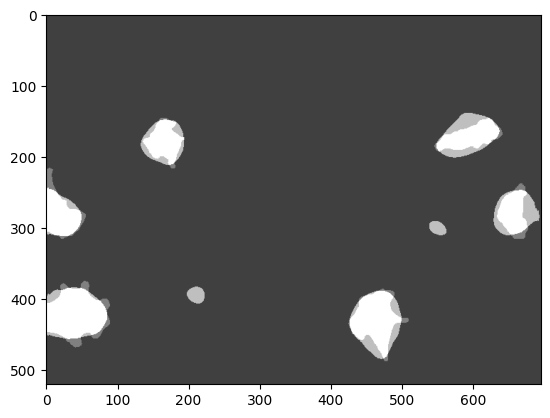

In [27]:
#Ploteo los resultados
plt.imshow(x_val[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(x_val[0,:,:,1], cmap="gray", alpha=0.5)
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()

Notamos que logra detectar las partículas bastante bien. Sin embargo, el último modelo entrenado (epochs = 32) detecta partes como partícula que realmente no son. Al incrementar los epochs este error disminuye.

In [28]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose

La red que se implementa a continuación es una red U-Net. Esta arquitectura es utilizada principalmente para segmentación de imágenes.

La estructura de esta red se caracteriza por su forma de U. Tiene una parte que desciende (encoder) y una parte que asciende (decoder). El encoder utiliza las convoluciones para extraer las características relevantes. El decoder utiliza la desconvolución para aumentar la resolución espacial.

Esto permite realizar segmentaciones más detalladas preservando tanto la información global como los detalles locales.

In [29]:
img_shape = (512, 512, 1)
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [30]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

In [31]:
#Compilo el modelo
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [32]:
#Entreno el modelo
model_unet.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=50, validation_split = 0.5, verbose = 1)

Epoch 1/50
8/8 [==============================] - 51s 3s/step - loss: 0.6191 - val_loss: 0.5787
Epoch 2/50
8/8 [==============================] - 12s 1s/step - loss: 0.5680 - val_loss: 0.4642
Epoch 3/50
8/8 [==============================] - 12s 1s/step - loss: 0.4188 - val_loss: 0.1866
Epoch 4/50
8/8 [==============================] - 12s 1s/step - loss: 0.3822 - val_loss: 0.2741
Epoch 5/50
8/8 [==============================] - 12s 2s/step - loss: 0.3640 - val_loss: 0.2085
Epoch 6/50
8/8 [==============================] - 12s 1s/step - loss: 0.3468 - val_loss: 0.2153
Epoch 7/50
8/8 [==============================] - 12s 1s/step - loss: 0.3378 - val_loss: 0.1960
Epoch 8/50
8/8 [==============================] - 12s 1s/step - loss: 0.3325 - val_loss: 0.2024
Epoch 9/50
8/8 [==============================] - 12s 1s/step - loss: 0.3150 - val_loss: 0.1812
Epoch 10/50
8/8 [==============================] - 12s 1s/step - loss: 0.2880 - val_loss: 0.1309
Epoch 11/50
8/8 [======================

In [33]:
red_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_12[0][0]']              
                                )                                                             

In [34]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

TensorShape([1, 512, 512, 1])

In [35]:
pred.numpy().max()

0.998548

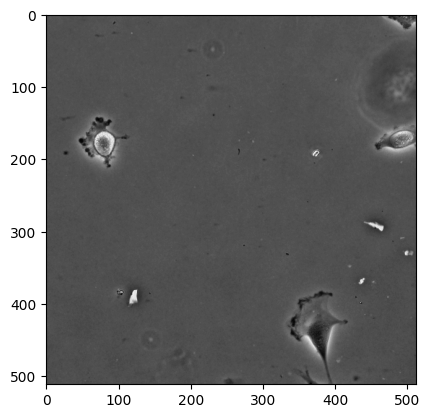

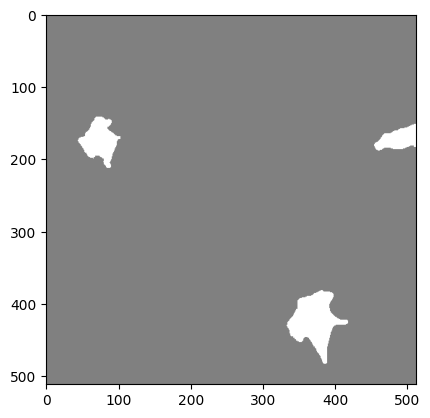

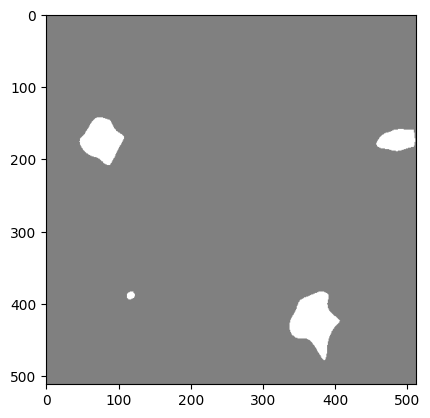

In [36]:
#Ploteo resultados
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha = 0.5)
plt.show()
plt.imshow(pred[0,:,:,0]>0.7, cmap="gray", alpha = 0.5)
plt.show()

Podemos ver que este modelo detecta con precisión las partículas.